In [529]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.datasets import load_iris
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [530]:
# df = pd.read_csv('data/kc_house_data.csv')

In [531]:
# import geopy.geocoders
# from geopy.geocoders import Nominatim
# geopy.geocoders.options.default_user_agent = 'kpmcdonough@gmail.com'
# geopy.geocoders.options.default_timeout = 7
# geolocator = Nominatim()
# print(geolocator.headers)
# print(geolocator.timeout)

In [532]:
# locator = Nominatim()
# coordinates = 47.7210, -122.319
# location = locator.reverse(coordinates)
# location.raw

In [533]:
# test_df = df.head()

In [534]:
# locator = Nominatim()

# def return_neighborhood(location):
#     if 'neighbourhood' in location['address'].keys():
#         return location['address']['neighbourhood']
#     elif 'suburb' in location['address'].keys():
#         return location['address']['suburb']
#     elif 'town' in location['address'].keys():
#         return location['address']['town']
#     elif 'hamlet' in location['address'].keys():
#         return location['address']['hamlet']
#     else:
#         return "N/A"

# test = []
# for row in df.index:
#     lat = df['lat'][row]
#     long = df['long'][row]
#     coords = lat,long
#     location = locator.reverse(coords)
#     location_dict = location.raw
#     test.append(return_neighborhood(location_dict))

# df


In [535]:
# test

In [536]:
# test[0]

In [537]:
# df['Neighborhood'] = 0
# df

# for row in df.index:
#     df["Neighborhood"][row] = test[row]
# df

In [538]:
# top_neighborhoods = df['Neighborhood'].value_counts()[0:251].index
# for row in df.index:
#     if df['Neighborhood'][row] in top_neighborhoods:
#         df['Neighborhood'][row] = df['Neighborhood'][row]
#     else:
#         df['Neighborhood'][row] = "Other"

In [539]:
# df["Neighborhood"].value_counts()

In [540]:
# for row in df.index:
#     if df['Neighborhood'][row] == "N/A":
#         df['Neighborhood'][row] = "Other"
# df['Neighborhood'].value_counts()

In [541]:
# df.to_csv('data/KC_with_hoods')

In [542]:
df = pd.read_csv('data/KC_with_hoods', index_col=0)

In [543]:
df.isna().sum()

id                    0
date                  0
price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
floors                0
waterfront         2376
view                 63
condition             0
grade                 0
sqft_above            0
sqft_basement         0
yr_built              0
yr_renovated       3842
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
Neighborhood          0
newly_renovated       0
dtype: int64

In [544]:
from sklearn.preprocessing import OrdinalEncoder

In [545]:
df.corr()['price']

id                -0.016772
price              1.000000
bedrooms           0.308787
bathrooms          0.525906
sqft_living        0.701917
sqft_lot           0.089876
floors             0.256804
waterfront         0.276295
view               0.395734
condition          0.036056
grade              0.667951
sqft_above         0.605368
yr_built           0.053953
yr_renovated       0.129599
zipcode           -0.053402
lat                0.306692
long               0.022036
sqft_living15      0.585241
sqft_lot15         0.082845
newly_renovated    0.010896
Name: price, dtype: float64

In [546]:
y = df["price"]
X = df.drop("price", axis=1)

In [547]:
cols = list(X.isna().sum().index)

In [548]:
relevant_cols = ['date','bedrooms','bathrooms','sqft_living','sqft_lot'\
                 ,'floors','waterfront','view','condition','grade','sqft_above', 'sqft_basement',\
                 'yr_built','yr_renovated','zipcode','sqft_living15','sqft_lot15','Neighborhood']

In [549]:
X = X[relevant_cols]

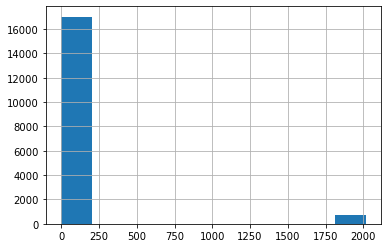

In [550]:
X['yr_renovated'].hist();

In [551]:
df['newly_renovated'] = df['yr_renovated'] > 2014

In [552]:
df.corr()['price']['newly_renovated']

0.010896324018133209

In [553]:
X = X.drop('yr_renovated', axis=1)

In [554]:
view = X[['view']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(view)
view_imputed = imputer.transform(view)
view_imputed

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [555]:
X['view'] = view_imputed

In [556]:
X['view'].isna().sum()

0

In [557]:
waterfront = X[['waterfront']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(waterfront)
waterfront_imputed = imputer.transform(waterfront)
waterfront_imputed
X['waterfront'] = waterfront_imputed

In [558]:
X['sqft_basement'] = X['sqft_basement'].apply(lambda x: np.nan if "?" in x else x)

In [559]:
basement = X[['sqft_basement']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(basement)
basement_imputed = imputer.transform(basement)
basement_imputed
X['sqft_basement'] = basement_imputed

In [560]:
X['sqft_basement']

0          0.0
1        400.0
2          0.0
3        910.0
4          0.0
         ...  
21592      0.0
21593      0.0
21594      0.0
21595      0.0
21596      0.0
Name: sqft_basement, Length: 21597, dtype: float64

In [561]:
X['sqft_grade'] = X['sqft_living'] * X['grade']

In [562]:
# X['sale'] = y
# X

# pf = PolynomialFeatures(degree=2)

# pf.fit(X)

In [563]:
# pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
# corr_df = pdf.corr()
# corr_df[corr_df['x15'] > .75]

In [564]:
# X['sqft_grade'] = X['sqft_living']*X['grade']
# X.corr()['sale']

In [565]:
X['Yr_sold'] = X['date'].apply(lambda x: x[-4:])
X['Mo_sold'] = X['date'].apply(lambda x: x[0:2])
X['Mo_sold'] = X['Mo_sold'].apply(lambda x: x[0:1] if "/" in x else x)

In [566]:
X = X.drop("date", axis=1)

In [567]:
from sklearn.preprocessing import OneHotEncoder

month = X[['Mo_sold']]


ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')


ohe.fit(month)


ohe.categories_

month_encoded = ohe.transform(month)

In [568]:
month_encoded = pd.DataFrame(

    month_encoded,

    columns=ohe.categories_[0],
 
    index=X.index
)


month_encoded
month_encoded = month_encoded.drop('10', axis=1)

In [569]:
X = pd.concat([X, month_encoded], axis=1)

In [570]:
from sklearn.preprocessing import OrdinalEncoder

year = X[['Yr_sold']]

encoder_year = OrdinalEncoder()
encoder_year.fit(year)

year_encoded = encoder_year.transform(year)


year_encoded = year_encoded.flatten()


year_encoded

X['year'] = year_encoded
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,12,2,3,4,5,6,7,8,9,year
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21593,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21594,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21595,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [571]:
X = X.drop('Yr_sold', axis=1)
X = X.drop('Mo_sold', axis=1)

In [572]:
X['Neighborhood'].value_counts()

Other              3304
Sammamish           886
Kirkland            701
Kent                566
Redmond             496
                   ... 
Coal Creek           12
Washington Park      12
Endolyne             11
Wyngates             11
Willow Ridge         11
Name: Neighborhood, Length: 251, dtype: int64

In [573]:
from sklearn.preprocessing import OneHotEncoder

hood = X[['Neighborhood']]


ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')


ohe.fit(hood)


ohe.categories_

hood_encoded = ohe.transform(hood)

In [574]:
hood_encoded = pd.DataFrame(

    hood_encoded,
  
    columns=ohe.categories_[0],
   
    index=X.index
)


hood_encoded
hood_encoded = hood_encoded.drop('Other', axis=1)

In [575]:
# X = pd.concat([X, hood_encoded], axis=1)

In [576]:
X['sqft_grade'] = X['sqft_living'] * X['grade']

In [577]:
X = X.drop('Neighborhood', axis=1)

In [578]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.695080716958244

In [579]:
X_no_dummies = X.iloc[:, : 16]

In [580]:
X_no_dummies

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,sqft_grade
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,1340,5650,8260
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,1690,7639,17990
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,2720,8062,4620
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,1360,5000,13720
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,1800,7503,13440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,98103,1530,1509,12240
21593,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,98146,1830,7200,18480
21594,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,98144,1020,2007,7140
21595,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,98027,1410,1287,12800


In [581]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_no_dummies, y)
model.score(X_no_dummies,y)

0.693225527970078

In [582]:
from sklearn.preprocessing import OneHotEncoder

zip = X_no_dummies[['zipcode']]


ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')


ohe.fit(zip)


ohe.categories_

zip_encoded = ohe.transform(zip)

In [583]:
zip_encoded = pd.DataFrame(

    zip_encoded,
  
    columns=ohe.categories_[0],
   
    index=X_no_dummies.index
)


zip_encoded

,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [584]:
X_zip_dummies = pd.concat([X_no_dummies, zip_encoded], axis=1)

In [585]:
model = LinearRegression()
model.fit(X_zip_dummies, y)
model.score(X_zip_dummies,y)

0.8394401048046631

In [586]:
X_no_dummies
SM_df = X_no_dummies.copy()

In [587]:
SM_df['price'] = y

In [588]:
multiple_formula = 'price ~' + '+'.join(SM_df.columns[0:-1])
multiple_model = ols(multiple_formula, SM_df).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     3048.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:05:33   Log-Likelihood:            -2.9463e+05
No. Observations:               21597   AIC:                         5.893e+05
Df Residuals:                   21580   BIC:                         5.894e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.367e+06   2.94e+06      3.185      0.001     3.6e+06    1.51e+07
bedrooms      -1.372e+04   1982.827     -6.918      0.000   -1.76e+04   -9831.672
bathrooms       5.45e+04   3278.096     16.625      0.000    4.81e+04    6.09e+04
sqft_living    -307.2310     19.956    -15.395      0.000    -346.346    -268.116
sqft_lot         -0.0290      0.048     -0.601      0.548      -0.124       0.066
floors         5.422e+04   3650.421     14.853      0.000    4.71e+04    6.14e+04
waterfront     5.853e+05   1.83e+04     31.928      0.000    5.49e+05    6.21e+05
view           3.802e+04   2136.324     17.795      0.000    3.38e+04    4.22e+04
condition      2.608e+04   2346.040     11.117      0.000    2.15e+04    3.07e+04
grade          1.122e+04   2987.745      3.755      0.000    5362.686    1.71e+04
sqft_above        4.1450     18.275      0.227      0.821     -31.675      39.965
sqft_basement    52.5859     18.109      2.904      0.004      17.091      88.080
yr_built      -3212.4610     67.191    -47.811      0.000   -3344.161   -3080.761
zipcode         -31.5669     29.543     -1.068      0.285     -89.474      26.340
sqft_living15    36.6704      3.448     10.635      0.000      29.912      43.429
sqft_lot15       -0.5265      0.074     -7.123      0.000      -0.671      -0.382
sqft_grade       48.6164      0.928     52.409      0.000      46.798      50.435
==============================================================================
Omnibus:                    10303.908   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           294981.153
Skew:                           1.711   Prob(JB):                         0.00
Kurtosis:                      20.779   Cond. No.                     2.17e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [589]:
X_no_dummies.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,sqft_grade
bedrooms,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,0.356563,0.479386,0.297229,0.155670,-0.154092,0.393406,0.030690,0.506704
bathrooms,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,0.665838,0.686668,0.278485,0.507173,-0.204786,0.569884,0.088303,0.738928
sqft_living,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,0.762779,0.876448,0.428660,0.318152,-0.199802,0.756402,0.184342,0.973752
sqft_lot,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,0.114731,0.184139,0.015031,0.052946,-0.129586,0.144763,0.718204,0.172951
floors,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,0.458794,0.523989,-0.241866,0.489193,-0.059541,0.280102,-0.010722,0.373290
waterfront,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,0.082818,0.071778,0.083050,-0.024487,0.028923,0.083823,0.030658,0.114449
view,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,0.249082,0.166017,0.270629,-0.054452,0.085059,0.278928,0.073083,0.296626
condition,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,-0.146896,-0.158904,0.168482,-0.361592,0.002888,-0.093072,-0.003126,-0.085574
grade,0.356563,0.665838,0.762779,0.114731,0.458794,0.082818,0.249082,-0.146896,1.000000,0.756073,0.165843,0.447865,-0.185771,0.713867,0.120981,0.848301
sqft_above,0.479386,0.686668,0.876448,0.184139,0.523989,0.071778,0.166017,-0.158904,0.756073,1.000000,-0.051175,0.424037,-0.261570,0.731767,0.195077,0.881953


In [590]:
X = X.drop('sqft_lot', axis=1)

In [591]:
X = X.drop('sqft_above', axis=1)

In [594]:
X = pd.concat([X, zip_encoded], axis=1)

In [595]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.8410224734217631

In [596]:
X

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,3,1.00,1180,1.0,0.0,0.0,3,7,0.0,1955,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3,2.25,2570,2.0,0.0,0.0,3,7,400.0,1951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.00,770,1.0,0.0,0.0,3,6,0.0,1933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.00,1960,1.0,0.0,0.0,5,7,910.0,1965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,2.00,1680,1.0,0.0,0.0,3,8,0.0,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0.0,0.0,3,8,0.0,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,4,2.50,2310,2.0,0.0,0.0,3,8,0.0,2014,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,2,0.75,1020,2.0,0.0,0.0,3,7,0.0,2009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,3,2.50,1600,2.0,0.0,0.0,3,8,0.0,2004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
